# python hands-on session

By: Ties de Kok  
Version: Python 2.7 (see any notes for Python 3.5)

1. handling files
2. data handling
3. **web scraping**
4. text mining
5. (interactive) visualisations

In [59]:
from IPython.display import Image, display

## Introduction

**Note:** In this notebook I will often build upon chapter 11 of 'automate the boring stuff' which is available here:  
https://automatetheboringstuff.com/chapter11/

Extracting information from webpages consists of four steps:
1. Construct or retrieve the URL
2. Have Python visit the URL and download the source of the page (often HTML)
3. If needed, parse the source-file
4. Extract the information you need

Depending on the website it can be very easy or very hard to extract the information.  

Websites can be classified into roughly two categories:
1. Computer oriented webpage: API (Application Program Interface)
2. Human oriented webpage: regular website

The first category is always the preferred option, however, it is not always available.

## Opening a website

We will use the `requests` module, the book 'automate the boring stuff' mentions it well:
> The requests module lets you easily download files from the Web without having to worry about complicated issues such as network errors, connection problems, and data compression. The requests module doesn’t come with Python, so you’ll have to install it first. **From the command line, run pip install requests.**

In the initial example I used the build-in `urllib2` module but for anything besides the simplest operations `requests` is a lot better

In [2]:
import requests

### Downloading a web page

In [3]:
res = requests.get('https://automatetheboringstuff.com/files/rj.txt')

In [8]:
type(res.text)

unicode

In [5]:
len(res.text)

174130

In [6]:
print(res.text[:250])

ï»¿The Project Gutenberg EBook of Romeo and Juliet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project


*Note:* The weird characters are due to Unicode, Python 2.7 has issues with Unicode, Python 3.5 a lot less.

## Using an API

Before we do any web-scraping it is important to check whether there is an API that we can use instead of the regular website.  
APIs are designed to be approached and 'read' by computers, whereas regular webpages are designed for humans not computers.  

An API, in a simplified sense, has two characteristics:
1. The URL contains parameters that formulate a request for information
2. The response by the server is in a machine-readible format.

The formats are usually either:
- Plain text
- JSON
- XML

### Example

Let's say we want to get rain radar data for Tilburg from http://www.buienradar.nl/  

We could go to the website using our browser and find the rainradar for Tilburg:  
http://www.buienradar.nl/inzoom?lat=51.56&lon=5.09

But, how can we actually extract the information that is on that webpage?  
We could spend a lot of time writing a program that can 'read' the page, but maybe there is an easier way!  

Googling for `Buienradar API` leads us to this webpage: http://gratisweerdata.buienradar.nl/ --> an API:  

http://gps.buienradar.nl/getrr.php?lat=51.56&lon=5.09 

This page is hard to read for us as humans, but a computer can 'read' this with ease. 

Remember the two characteristics of an API:
1. We can use the `lat=` and `lon=` parameters in the URL to request information
2. The response is returned as plain text

###  Retrieve the rainradar information for a custom location using Python

One of the big benefits of the `requests` library is that it makes it easy to pass parameters.  
See: http://docs.python-requests.org/en/master/user/quickstart/#passing-parameters-in-urls

In [9]:
payload = {'lat' : 51.56, 'lon' : 5.09}
res = requests.get('http://gps.buienradar.nl/getrr.php?', params=payload)

In [11]:
print(res.url)

http://gps.buienradar.nl/getrr.php?lat=51.56&lon=5.09


The response is in plain text. Notice the difference between:  
**Raw text:**

In [12]:
res.text

u'000|11:25\r\n000|11:30\r\n000|11:35\r\n000|11:40\r\n000|11:45\r\n000|11:50\r\n000|11:55\r\n000|12:00\r\n000|12:05\r\n000|12:10\r\n000|12:15\r\n000|12:20\r\n000|12:25\r\n000|12:30\r\n000|12:35\r\n000|12:40\r\n000|12:45\r\n000|12:50\r\n000|12:55\r\n000|13:00\r\n000|13:05\r\n000|13:10\r\n000|13:15\r\n000|13:20\r\n000|13:25\r\n'

**Printed text:**

In [13]:
print(res.text)

000|11:25
000|11:30
000|11:35
000|11:40
000|11:45
000|11:50
000|11:55
000|12:00
000|12:05
000|12:10
000|12:15
000|12:20
000|12:25
000|12:30
000|12:35
000|12:40
000|12:45
000|12:50
000|12:55
000|13:00
000|13:05
000|13:10
000|13:15
000|13:20
000|13:25



### Wrap it into a function

If you repeat an operation many times (like requesting the rain data for many locations) it is often a good idea to create a function

In [14]:
def get_rain_data(lat, lon):
    payload = {'lat' : lat, 'lon' : lon}
    res = requests.get('http://gps.buienradar.nl/getrr.php?', params=payload)
    return res.text

In [40]:
rain_tilburg = get_rain_data(51.56, 5.09)
rain_tilburg

u'000|11:40\r\n000|11:45\r\n000|11:50\r\n000|11:55\r\n000|12:00\r\n000|12:05\r\n000|12:10\r\n000|12:15\r\n000|12:20\r\n000|12:25\r\n000|12:30\r\n000|12:35\r\n000|12:40\r\n000|12:45\r\n000|12:50\r\n000|12:55\r\n000|13:00\r\n000|13:05\r\n000|13:10\r\n000|13:15\r\n000|13:20\r\n000|13:25\r\n000|13:30\r\n000|13:35\r\n000|13:40\r\n'

### Parse a plain text response

Parsing, in simplified terms, means converting the raw file into something that our code can 'understand'.

In [41]:
rain_tilburg = rain_tilburg.strip().split('\r\n')
rain_tilburg[0:4]

[u'000|11:40', u'000|11:45', u'000|11:50', u'000|11:55']

In [43]:
rain_tilburg = {x.split('|')[1] : int(x.split('|')[0]) / 255 for x in rain_tilburg}

*Note:* The return value is between 0 (no rain) to 255 (heavy rain) so we divide by 255 to make it easier to interpret

In [44]:
rain_tilburg['12:05']

0

**Note:** If the above gives an error, make sure to change it to a time that is actually included.

### Parsing JSON

JSON is usually very easy to parse as it is a machine readible format to begin with.  
See for example http://docs.python-requests.org/en/master/user/quickstart/#json-response-content

## Web scraping using Regular Expressions

For very basic webscraping it is possible to use Regular Expression to select parts of an HTML page.  
**However, for most applications it is a lot better to use a module developed for parsing HTML, like Beautiful Soup.**

### The SSRN example

This is the method used in the example of the first session, where we retrieved information from an SSRN page.  
I will briefly repeat it:

The goal is to get the *title*, *author*, and *publication date* of a webpage:  
e.g. http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2610429


In [51]:
import re

In [45]:
def get_ssrn_data(ID):
    payload = {'abstract_id' : ID}
    res = requests.get('http://papers.ssrn.com/sol3/papers.cfm?', params=payload)
    return res.text

In [55]:
html_text = get_ssrn_data(2610429)

Now, this is the raw source text of an HTML page, so we need to parse it into something we can actually use

In [49]:
html_text[:350]

u'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN""http://www.w3.org/TR/html4/strict.dtd">\r\n<HTML><HEAD><TITLE>Service Unavailable</TITLE>\r\n<META HTTP-EQUIV="Content-Type" Content="text/html; charset=us-ascii"></HEAD>\r\n<BODY><h2>Service Unavailable</h2>\r\n<hr><p>HTTP Error 503. The service is unavailable.</p>\r\n</BODY></HTML>\r\n'

In this example we will use the observation that some information is included in meta tags:
    ><title>Financial Accounting Research, Practice, and Financial Accountability by Mary E. Barth :: SSRN</title>
    
    <meta name="citation_author" content="Barth, Mary E.">
    <meta name="citation_title" content="Financial Accounting Research, Practice, and Financial Accountability">
    <meta name="citation_online_date" content="2015/05/26">

This makes it relatively easy and consistent to extract this content using Regular Expressions:

In [56]:
re.findall(r'<meta name="citation_author" content="(.*)">', html_text)

[u'Barth, Mary E.']

In [57]:
re.findall(r'<meta name="citation_title" content="(.*)">', html_text)[0]

u'Financial Accounting Research, Practice, and Financial Accountability'

In [58]:
re.findall(r'<meta name="citation_online_date" content="(.*)">', html_text)[0]

u'2015/05/26'

## Web scraping using BeautifulSoup

In the example above we treat a HTML page as-if it is plain text.  
However, HTML is a format in which we write web pages, so it actually has an underlying structure that we can use.

A quick refresher on HTML from 'automate the boring stuff':

> In case it’s been a while since you’ve looked at any HTML, here’s a quick overview of the basics. An HTML file is a plaintext file with the .html file extension. The text in these files is surrounded by tags, which are words enclosed in angle brackets. The tags tell the browser how to format the web page. A starting tag and closing tag can enclose some text to form an element. The text (or inner HTML) is the content between the starting and closing tags. For example, the following HTML will display Hello world! in the browser, with Hello in bold:

    <strong>Hello</strong> world!

You can view the HTML source by right-clicking a page and selecting `view page source`:

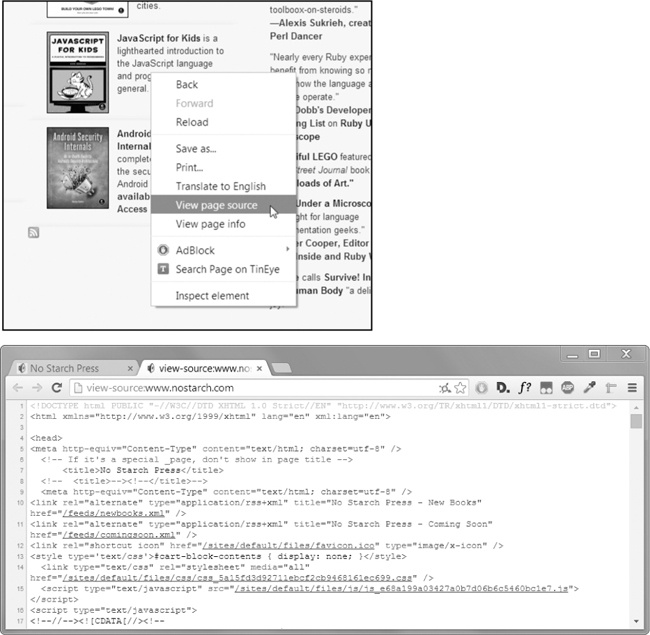

In [60]:
Image('https://automatetheboringstuff.com/images/000009.jpg')

### Get started

We will use the so-called `BeautifulSoup` module to parse HTML pages, run from the command line:

    pip install beautifulsoup4
    
The module name itself is the abbrevation `bs4`

In [61]:
import bs4

### Create a BeautifulSoup Object

For this example we will follow 'automate the boring stuff' and retrieve data from:  
http://nostarch.com

In [63]:
res = requests.get('http://nostarch.com')
noStarchSoup = bs4.BeautifulSoup(res.text)
type(noStarchSoup)

bs4.BeautifulSoup

### Retrieve information from the BeautifulSoup object

The goal is to, somehow, retrieve the content of a particular section of the HTML document.  
Now, HTML is like a hierarchical structure, so we can try to select a particular part based on the location in the structure.  

There are two ways to go about this:  
1. Using a `css-selector`
2. Using an `XPath`

BeautifulSoup accepts a `css-selector` expression for the `select()` method.  

I will not go into much detail on these `css-selectors` but this links lists several tutorials:  
https://automatetheboringstuff.com/list-of-css-selector-tutorials/

### A pragmatic way to go about making CSS selectors

Creating CSS selectors manually can be a lot of work and require some knowledge on how HTML and CSS works.  
However, there are tools available that allow you to select what you want and have it generate a CSS selector expression.  

For example, if you use Chrome you can use the `SelectorGadget` extension.  
This extension allows you to select what you want and do not want, and it will generate an expression you can use with BeautifulSoup.

### For example:
Let's say we want to extract the title of the first element in the 'New' column:

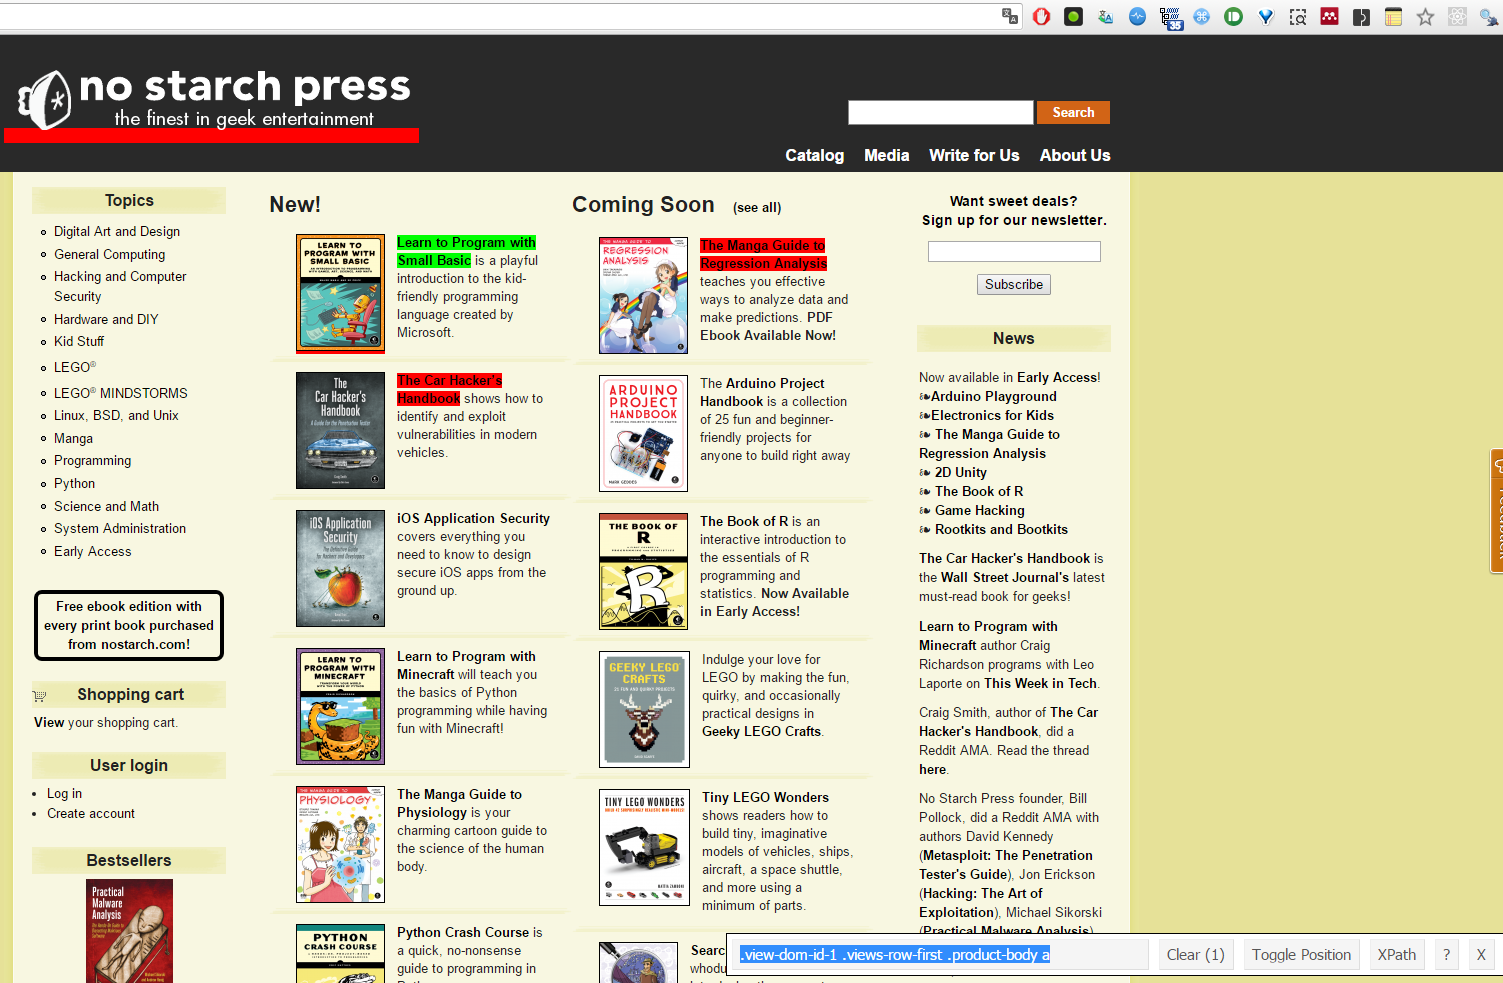

In [72]:
Image('https://dl.dropboxusercontent.com/u/1265025/python_tut/python_css.PNG')

*Note:* The number between brackets after 'Clear' indicates the number of elements selected.

### Extract the text from that one element

In [73]:
first_new = noStarchSoup.select('.view-dom-id-1 .views-row-first .product-body a')

In [76]:
first_new[0].getText()

u'Learn to Program with Small Basic'

In [77]:
first_new[0].attrs

{'href': 'https://www.nostarch.com/smallbasic'}

### Extract all the new elements

In [78]:
all_new = noStarchSoup.select('.view-dom-id-1 .product-body a')

In [79]:
for x in all_new:
    print(x.getText())

Learn to Program with Small Basic
The Car Hacker’s Handbook
iOS Application Security
Learn to Program with Minecraft
The Manga Guide to Physiology
Python Crash Course
The Official ScratchJr Book
The Maker's Guide to the Zombie Apocalypse
Clojure for the Brave and True
Junkyard Jam Band
Python Playground
 The LEGO Power Functions Idea Book, Vol. 1
The LEGO Architect
The LEGO Adventure Book, Volume 3
Beautiful LEGO: Wild!
The Art of LEGO Scale Modeling


### Extract bestsellers

In [80]:
all_bestsellers = noStarchSoup.select('.imagecache-product_linked .imagecache-product')

In [93]:
all_bestsellers[0].attrs

{'alt': 'Practical Malware Analysis',
 'class': ['imagecache', 'imagecache-product'],
 'height': '115',
 'src': 'https://www.nostarch.com/sites/default/files/imagecache/product/practical_malware_analysis.png',
 'title': 'Practical Malware Analysis',
 'width': '87'}

In [95]:
for x in all_bestsellers:
    print(x.attrs['title'])

Practical Malware Analysis
The LEGO Neighborhood Book
Super Scratch Programming Adventure! 
Teach Your Kids to Code



## Advanced webscraping using Scrapy

In the examples above we provide the URLs in advance.  
Sometimes you want to create a `spider` which basically 'walks' through webpages and crawls the information.  

In other words, you might want to create a spider that visits webpages without specifying all the URLs upfront.  

This, obviously, requires more programming but it can be achieved with frameworks such as `Scrapy`.  
http://scrapy.org/

Using this framework requires some more time investment, but if you are serious about web-crawling this is the way to go.  
`Scrapy` also allows 'spiders' to click on links or use login forms, amongst many other things.

## Advanced webscraping using Selenium

Sometimes you need to interact with a webpage in a way that is not achievable by using URLs.  
For example, you might need to first login before being able to reach a web-page.  

In many cases you can use the `scrapy` framework but an alternative that sometimes works better is the `selenium` Module:

> The selenium module lets Python directly control the browser by programmatically clicking links and filling in login information, almost as though there is a human user interacting with the page. Selenium allows you to interact with web pages in a much more advanced way than Requests and Beautiful Soup; but because it launches a web browser, it is a bit slower and hard to run in the background if, say, you just need to download some files from the Web.

I will not discuss it here, but it is included here:

https://automatetheboringstuff.com/chapter11/ 'Controlling the Browser with the selenium Module'